In [1]:
import pandas as pd
import numpy as np
import os

csv_file_map = {}

for root, dirs, files in os.walk('20250423'):
    for file in files:
        if file.endswith('.csv'):
            label = file.split('.')[0]
            if label not in csv_file_map:
                csv_file_map[label] = []
            csv_file_map[label].append(os.path.join(root, file))

In [2]:
X_Signal_Data = []
Y_Signal_Data = []

for label, file_paths in csv_file_map.items():
    for file_path in file_paths:
        data = pd.read_csv(file_path).to_numpy().flatten()
        data = data / np.max(np.abs(data))
        data = data - np.median(data)
        X_Signal_Data.append(data)
        Y_Signal_Data.append(label.split('_')[0])  # Assuming the label is the first part of the filename


In [3]:
Label_Map = {}
for i, label in enumerate(set(Y_Signal_Data)):
    Label_Map[label] = i

In [4]:
Label_Map

{'chopsticks': 0, 'empty': 1, 'noise': 2}

In [5]:
X_FFT_Data = []

for data in X_Signal_Data:
    fft_data = np.fft.rfft(data)
    fft_data = np.abs(fft_data)
    X_FFT_Data.append(fft_data)

Y_FFT_Data = []

for label in Y_Signal_Data:
    Y_FFT_Data.append(Label_Map[label])

X_FFT_Data = np.array(X_FFT_Data)
Y_FFT_Data = np.array(Y_FFT_Data)

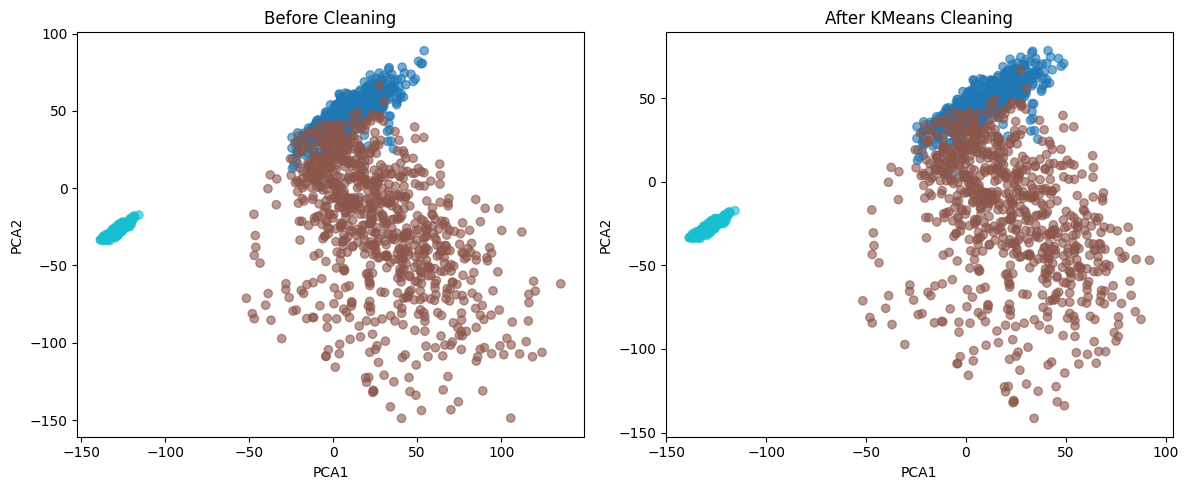

In [6]:
from sklearn.cluster import KMeans

# 设定聚类数，比如每个label聚成1类
n_clusters = len(set(Y_FFT_Data))
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(X_FFT_Data)

# 计算每个点到其聚类中心的距离
distances = np.linalg.norm(X_FFT_Data - kmeans.cluster_centers_[labels], axis=1)

# 设定距离阈值（如距离大于均值+2倍标准差的为异常点）
threshold = distances.mean() + 2 * distances.std()
mask = distances < threshold

# 清洗后的数据
X_FFT_Clean = X_FFT_Data[mask]
Y_FFT_Clean = Y_FFT_Data[mask]

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 用PCA降到2维方便可视化
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_FFT_Data)
X_clean_vis = pca.transform(X_FFT_Clean)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Before Cleaning")
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=Y_FFT_Data, cmap='tab10', alpha=0.6)
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.subplot(1, 2, 2)
plt.title("After KMeans Cleaning")
plt.scatter(X_clean_vis[:, 0], X_clean_vis[:, 1], c=Y_FFT_Clean, cmap='tab10', alpha=0.6)
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()

In [7]:
X_Train = np.abs(np.fft.rfft(np.array(X_Signal_Data)[mask], axis=1, n=266 * 2 - 1))
Y_Train = np.array(Y_Signal_Data)[mask]



In [8]:
X_Train.shape

(1540, 266)

Epoch 1/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5643 - loss: 1.3454 - val_accuracy: 0.7305 - val_loss: 0.9873
Epoch 2/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7030 - loss: 1.0202 - val_accuracy: 0.7435 - val_loss: 0.9230
Epoch 3/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7307 - loss: 0.9551 - val_accuracy: 0.7403 - val_loss: 0.8951
Epoch 4/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7443 - loss: 0.8876 - val_accuracy: 0.7403 - val_loss: 0.9157
Epoch 5/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7716 - loss: 0.8225 - val_accuracy: 0.7045 - val_loss: 0.8954
Epoch 6/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7637 - loss: 0.8302 - val_accuracy: 0.7565 - val_loss: 0.8225
Epoch 7/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8370 - loss: 0.7203 - val_accuracy: 0.8117 - val_loss: 0.8692
Epoch 8/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8727 - loss: 0.7007 - val_accuracy

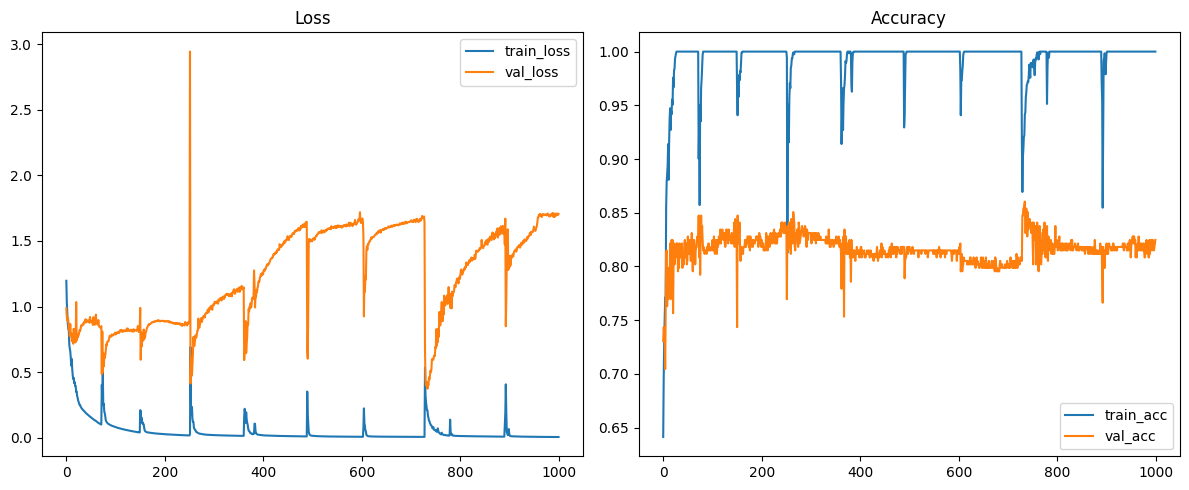

In [ ]:
# 新增一个代码单元，建议放在最后

import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from sklearn.model_selection import train_test_split

# 假设X_Train.shape = (样本数, 266)，Y_Train为标签（字符串或数字）
# 如果Y_Train不是数字标签，请先做编码
if Y_Train.dtype.type is np.str_ or Y_Train.dtype.type is np.object_:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    Y_Train = le.fit_transform(Y_Train)

# One-hot编码
Y_Train_cat = tf.keras.utils.to_categorical(Y_Train, num_classes=3)

# 划分训练和验证集
X_tr, X_val, y_tr, y_val = train_test_split(X_Train, Y_Train_cat, test_size=0.2, random_state=42)
    
# 构建模型
model = models.Sequential([
    layers.Input(shape=(266,)),
    layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l1(1e-4)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-4)),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 训练模型
history = model.fit(X_tr, y_tr, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

# 绘制训练过程
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


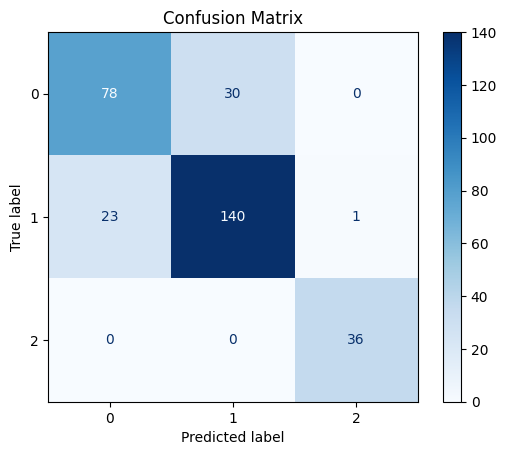

In [10]:
# 新增代码单元，放在模型训练和loss/accuracy曲线之后

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 预测
y_pred = model.predict(X_val)
y_pred_label = np.argmax(y_pred, axis=1)
y_true_label = np.argmax(y_val, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_true_label, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# 新增代码单元，放在混淆矩阵之后

# 用模型预测所有训练集（X_Train），并筛选预测正确的数据
y_train_pred = model.predict(X_Train)
y_train_pred_label = np.argmax(y_train_pred, axis=1)

# 若Y_Train为one-hot编码则需要argmax，否则直接比较
if len(Y_Train.shape) > 1 and Y_Train.shape[1] > 1:
    y_train_true_label = np.argmax(Y_Train, axis=1)
else:
    y_train_true_label = Y_Train

correct_mask = (y_train_pred_label == y_train_true_label)

# 获得模型判定为“正确”的数据
X_Correct = X_Train[correct_mask]
Y_Correct = Y_Train[correct_mask]

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


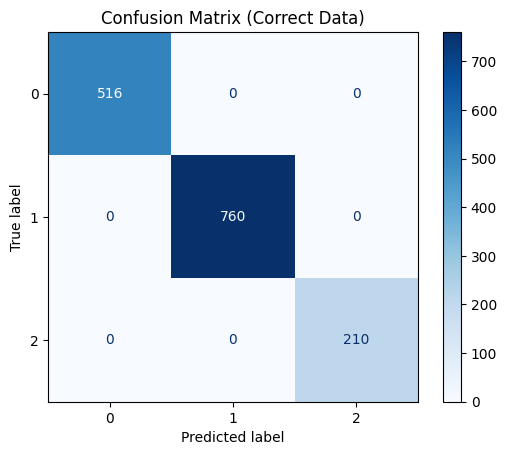

In [13]:
# 新增代码单元，放在 X_Correct/Y_Correct 之后

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 用模型对 X_Correct 重新预测
y_correct_pred = model.predict(X_Correct)
y_correct_pred_label = np.argmax(y_correct_pred, axis=1)

# 若 Y_Correct 为 one-hot 编码则需要 argmax，否则直接比较
if len(Y_Correct.shape) > 1 and Y_Correct.shape[1] > 1:
    y_correct_true_label = np.argmax(Y_Correct, axis=1)
else:
    y_correct_true_label = Y_Correct

# 绘制混淆矩阵
cm = confusion_matrix(y_correct_true_label, y_correct_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Correct Data)')
plt.show()